## Demo 2 - Uma implementação de DCGANs usando a técnica de convolução transposta e a biblioteca Keras.

- Dados

Redimensionar as imagens do CIFAR-10 entre -1 e 1.

- Gerador

Usar o inverso da convolução, chamada de convolução transposta.

Ativação de ReLU e BatchNormalization.

A entrada para o gerador é a distribuição normal z ou amostra latente (100 valores).

A última ativação é tanh.

- Discriminador

Usamos uma rede neural convolucional.

Ativação LeakyReLU e BatchNormalization.

A última ativação é sigmóide.

- Perda

binary_crossentropy

- Otimizador

Adam (lr = 0,0003, beta_1 = 0,5)
batch_size = 64
épocas = 100

In [0]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.layers import Concatenate, GaussianNoise,Activation
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras import initializers
from keras import backend as K

Using TensorFlow backend.


In [0]:
# Carregando nosso dataset

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


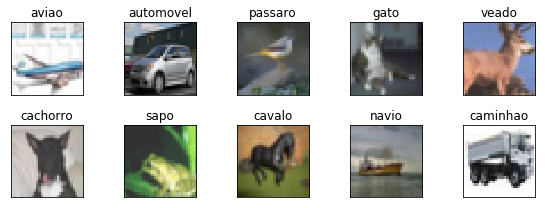

In [0]:
num_classes = len(np.unique(y_train))
class_names = ['aviao','automovel','passaro','gato','veado',
               'cachorro','sapo','cavalo','navio','caminhao']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

In [0]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'amostras de treinamento')
print(X_test.shape[0], 'amostras de teste')

X_train shape: (50000, 32, 32, 3)
50000 amostras de treinamento
10000 amostras de teste


In [0]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# Convertendo nossos vetores de classes para representações 
# em matrizes de classe binárias

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# O gerador está usando a ativação de tanh, para a qual precisamos pré-processar
# os dados da imagem em um intervalo entre -1 e 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)


In [0]:
print(X_train[0].shape)

(32, 32, 3)


In [0]:
# Espaço dimensional latente

z = Input(shape=(100,))

# Classes

labels = Input(shape=(10,))

# Rede geradora

merged_layer = Concatenate()([z, labels])

# FC: 2x2x512

generator = Dense(2*2*512, activation='relu')(merged_layer)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)
generator = Reshape((2, 2, 512))(generator)

# # Conv 1: 4x4x256

generator = Conv2DTranspose(256, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 2: 8x8x128

generator = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 3: 16x16x64

generator = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 4: 32x32x3

generator = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(generator)

# generator = Model(inputs=[z, labels], outputs=out_g)

generator = Model(inputs=[z, labels], outputs=generator, name='generator')

W0814 17:07:59.832589 140697696442240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 17:07:59.856574 140697696442240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 17:07:59.867757 140697696442240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0814 17:08:00.015865 140697696442240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0814 17:08:00.368740 

In [0]:
# Sumário representativo de nosso modelo

generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2048)         227328      concatenate_1[0][0]              
__________

In [0]:
# Imagem de entrada

img_input = Input(shape=(X_train[0].shape))

# Conv 1: 16x16x64

discriminator = Conv2D(64, kernel_size=5, strides=2, padding='same')(img_input)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 2:

discriminator = Conv2D(128, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 3: 

discriminator = Conv2D(256, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 4: 

discriminator = Conv2D(512, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# FC

discriminator = Flatten()(discriminator)

# Concatenação

merged_layer = Concatenate()([discriminator, labels])
discriminator = Dense(512, activation='relu')(merged_layer)
    
# Saída

discriminator = Dense(1, activation='sigmoid')(discriminator)

discriminator = Model(inputs=[img_input, labels], outputs=discriminator, name='discriminator')

In [0]:
# Sumário representativo de nosso modelo

discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   4864        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 16, 16, 64)   0           batch_normalization_5[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
# Otimizador

discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

W0814 17:08:02.582081 140697696442240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0814 17:08:02.599689 140697696442240 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
discriminator.trainable = False

label = Input(shape=(10,), name='label')
z = Input(shape=(100,), name='z')

fake_img = generator([z, label])
validity = discriminator([fake_img, label])

d_g = Model([z, label], validity, name='adversarial')

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [0]:
# Sumário representativo de nosso modelo

d_g.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  (None, 100)          0                                            
__________________________________________________________________________________________________
label (InputLayer)              (None, 10)           0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 32, 32, 3)    4543363     z[0][0]                          
                                                                 label[0][0]                      
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            5365121     generator[1][0]                  
          

epoch = 1/100, d_loss=0.322, g_loss=3.056                                                                                                     


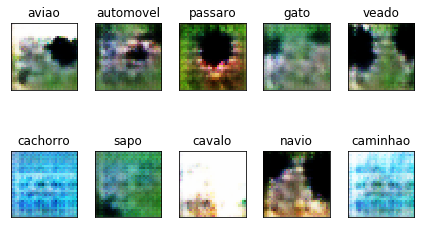

epoch = 2/100, d_loss=0.348, g_loss=2.819                                                                                                     
epoch = 3/100, d_loss=0.288, g_loss=3.400                                                                                                     
epoch = 4/100, d_loss=0.452, g_loss=5.340                                                                                                     
epoch = 5/100, d_loss=0.414, g_loss=2.788                                                                                                     
epoch = 6/100, d_loss=0.436, g_loss=6.067                                                                                                     
epoch = 7/100, d_loss=0.502, g_loss=4.762                                                                                                     
epoch = 8/100, d_loss=0.241, g_loss=3.481                                                                                                     

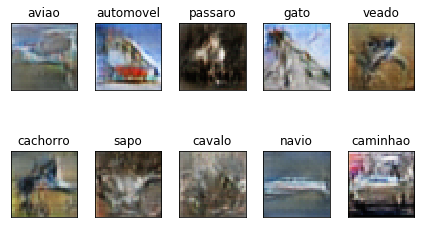

epoch = 12/100, d_loss=0.192, g_loss=1.803                                                                                                     
epoch = 13/100, d_loss=0.385, g_loss=1.419                                                                                                     
epoch = 14/100, d_loss=0.169, g_loss=1.351                                                                                                     
epoch = 15/100, d_loss=0.166, g_loss=0.334                                                                                                     
epoch = 16/100, d_loss=0.163, g_loss=0.113                                                                                                     
epoch = 17/100, d_loss=0.173, g_loss=0.136                                                                                                     
epoch = 18/100, d_loss=0.168, g_loss=0.239                                                                                              

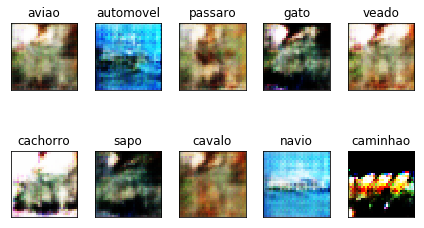

epoch = 22/100, d_loss=0.165, g_loss=16.061                                                                                                     
epoch = 23/100, d_loss=0.166, g_loss=16.118                                                                                                     
epoch = 24/100, d_loss=0.163, g_loss=16.118                                                                                                     
epoch = 25/100, d_loss=0.177, g_loss=0.238                                                                                                     
epoch = 26/100, d_loss=0.170, g_loss=2.821                                                                                                     
epoch = 27/100, d_loss=0.165, g_loss=16.118                                                                                                     
epoch = 28/100, d_loss=0.163, g_loss=16.118                                                                                         

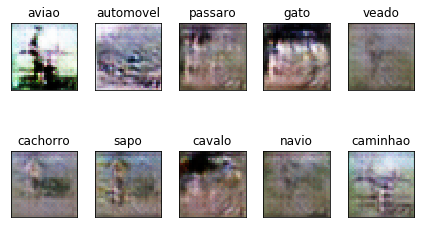

epoch = 32/100, d_loss=0.164, g_loss=0.305                                                                                                     
epoch = 33/100, d_loss=0.169, g_loss=4.105                                                                                                     
epoch = 34/100, d_loss=0.168, g_loss=16.118                                                                                                     
epoch = 35/100, d_loss=0.164, g_loss=2.681                                                                                                     
epoch = 36/100, d_loss=0.170, g_loss=16.118                                                                                                     
epoch = 37/100, d_loss=0.164, g_loss=16.118                                                                                                     
epoch = 38/100, d_loss=0.165, g_loss=7.986                                                                                           

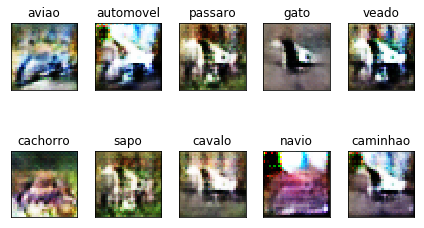

epoch = 42/100, d_loss=0.250, g_loss=4.243                                                                                                     
epoch = 43/100, d_loss=0.178, g_loss=7.438                                                                                                     
epoch = 44/100, d_loss=0.202, g_loss=6.423                                                                                                     
epoch = 45/100, d_loss=0.184, g_loss=8.045                                                                                                     
epoch = 46/100, d_loss=0.169, g_loss=3.697                                                                                                     
epoch = 47/100, d_loss=0.172, g_loss=9.817                                                                                                     
epoch = 48/100, d_loss=0.173, g_loss=13.114                                                                                             

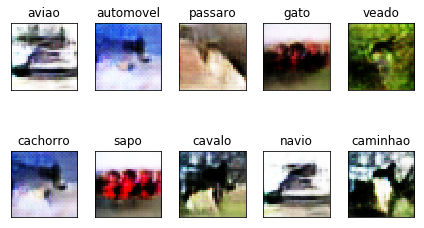

epoch = 52/100, d_loss=0.179, g_loss=5.499                                                                                                     
epoch = 53/100, d_loss=0.180, g_loss=6.530                                                                                                     
epoch = 54/100, d_loss=0.232, g_loss=6.850                                                                                                     
epoch = 55/100, d_loss=0.214, g_loss=6.320                                                                                                     
epoch = 56/100, d_loss=0.175, g_loss=9.735                                                                                                     
epoch = 57/100, d_loss=0.166, g_loss=10.366                                                                                                     
epoch = 58/100, d_loss=0.193, g_loss=8.931                                                                                             

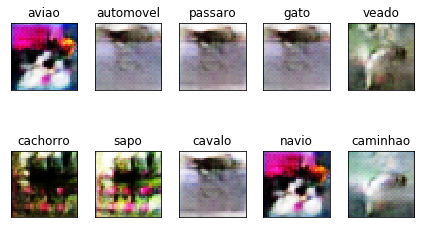

epoch = 62/100, d_loss=0.173, g_loss=2.982                                                                                                     
epoch = 63/100, d_loss=0.185, g_loss=8.666                                                                                                     
epoch = 64/100, d_loss=0.314, g_loss=10.692                                                                                                     
epoch = 65/100, d_loss=0.207, g_loss=9.746                                                                                                     
epoch = 66/100, d_loss=0.180, g_loss=11.294                                                                                                     
epoch = 67/100, d_loss=0.212, g_loss=5.778                                                                                                     
epoch = 68/100, d_loss=0.168, g_loss=15.585                                                                                           

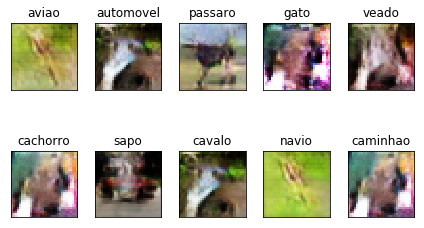

epoch = 72/100, d_loss=0.169, g_loss=12.863                                                                                                     
epoch = 73/100, d_loss=0.170, g_loss=7.840                                                                                                     
epoch = 74/100, d_loss=0.188, g_loss=2.546                                                                                                     
epoch = 75/100, d_loss=0.227, g_loss=12.699                                                                                                     
epoch = 76/100, d_loss=0.238, g_loss=10.402                                                                                                     
epoch = 77/100, d_loss=0.189, g_loss=12.847                                                                                                     
epoch = 78/100, d_loss=0.167, g_loss=10.734                                                                                         

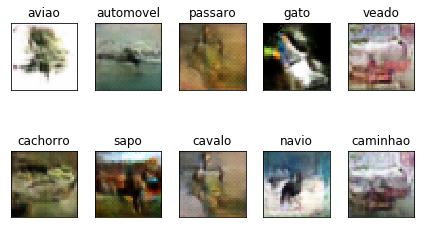

epoch = 82/100, d_loss=0.180, g_loss=10.546                                                                                                     
epoch = 83/100, d_loss=0.170, g_loss=6.252                                                                                                     
epoch = 84/100, d_loss=0.172, g_loss=8.630                                                                                                     
epoch = 85/100, d_loss=0.172, g_loss=7.664                                                                                                     
epoch = 86/100, d_loss=0.203, g_loss=5.864                                                                                                     
epoch = 87/100, d_loss=0.176, g_loss=9.654                                                                                                     
epoch = 88/100, d_loss=0.166, g_loss=10.193                                                                                            

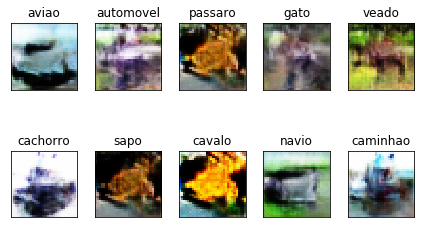

epoch = 92/100, d_loss=0.190, g_loss=6.804                                                                                                     
epoch = 93/100, d_loss=0.169, g_loss=8.409                                                                                                     
epoch = 94/100, d_loss=0.172, g_loss=12.763                                                                                                     
epoch = 95/100, d_loss=0.175, g_loss=14.318                                                                                                     
epoch = 96/100, d_loss=0.167, g_loss=11.989                                                                                                     
Buffered data was truncated after reaching the output size limit.

In [0]:
epochs = 100
batch_size = 32
smooth = 0.1
latent_dim = 100

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Treinamendo os pesos de nosso discriminador
        
        discriminator.trainable = True
        
        # Amostras reais
        
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = to_categorical(y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=10)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels],
                                                   y=real * (1 - smooth))
        
        # Amostras falsas
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Perda de nosso discriminador
        
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Treinando os pesos de nosso gerador
        
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = to_categorical(np.arange(0, 10).reshape(-1, 1), num_classes=10)
        
        x_fake = generator.predict([z, labels])
        x_fake = np.clip(x_fake, -1, 1)
        x_fake = (x_fake + 1) * 127
        x_fake = np.round(x_fake).astype('uint8')

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(x_fake[k])
            plt.title(class_names[k])

        plt.tight_layout()
        plt.show()

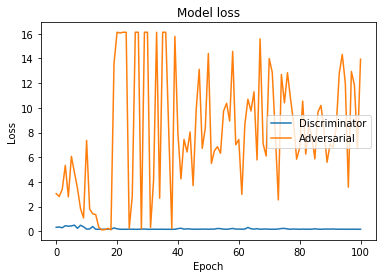

In [0]:
# Plotando nossas métricas de avaliação do modelo

plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()